In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [316]:
def model_multi_kernel_shape(n_out, input_shape, out_activation='softmax'):
    """

    Symbolic summary:
    > c2' - p2 - c2 - p2 - c2 - p2 - c2 - p3 - d1
    where c2' -> multiple kernel shapes

    Parameters
    ----------
        n_out: integer, number of output nodes
        input_shape: tuple, an input shape, which doesn't include batch-axis.
        out_activation: activation function on the output
    """
    audio_input = Input(shape=input_shape)

    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)

    x1 = Conv2D(7, (20, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x2 = Conv2D(7, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x3 = Conv2D(7, (3, 20), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    x = Concatenate(axis=channel_axis)([x1, x2, x3])

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation, kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    model = Model(audio_input, out)

    return model

def data_gen(audio_data, n_detect, nsp_excerpt, type_excerpt, hop_length=HOP_LENGTH):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    while True:
        for i in range(n_detect):
            
            if type_excerpt == 'onset':
                src_batch = np.array([audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)]], dtype=K.floatx())
            elif type_excerpt == 'segment':
                src_batch = np.array([np.tile(audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)],tile_times)[:NSP_SRC]],
                                     dtype=K.floatx())
                
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible
            
            yield src_batch
            
def performance_pedalseg(filename,fscore,precision,recall):
    print("-" * 60)
    print("{}".format(filename))
    print(" Accuracy: {0:.4f}".format(accuracy))
    print("Precision: {0:.4f}".format(precision[1]))
    print("   Recall: {0:.4f}".format(recall[1]))
    print("       F1: {0:.4f}".format(fscore[1]))

In [3]:
dataset_name = 'pedal-times_test.npz'
model_name = 'multi_kernel'

segment_exp_name = 'segment_{}'.format(model_name)
onset_exp_name = 'onset_{}'.format(model_name)
reg_w = 1e-4
batch_size = 1

threshold = 0.98

print("-" * 60)
print("Beici: Welcome! Lets do something deep with {}.".format(dataset_name))
print("       We're gonna use {} model.".format(model_name))
npz_path = os.path.join(DIR_PEDAL_METADATA, dataset_name)
tracks = np.load(npz_path)
filenames = tracks['filename']

print("Beici: Getting model...")
onset_model = model_multi_kernel_shape(n_out=2,input_shape=ONSET_INPUT_SHAPE)
onset_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
segment_model = model_multi_kernel_shape(n_out=2,input_shape=SEGMENT_INPUT_SHAPE)
segment_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print("       Loading the best weights...")
onset_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(onset_exp_name)))
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(segment_exp_name)))

------------------------------------------------------------
Beici: Welcome! Lets do something deep with pedal-times_test.npz.
       We're gonna use multi_kernel model.
Beici: Getting model...
       Loading the best weights...


In [310]:
# for idx, filename in enumerate(filenames):
filename = filenames[0]    
paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
paudio, sr = librosa.load(paudio_path, sr=SR) 

In [312]:
print("Beici: Predicting...")
len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
onsethop_length = HOP_LENGTH*10
onsethop_duration = onsethop_length/SR
n_ponset = int(np.ceil((len(paudio)-len_onset_shape)/onsethop_length))
gen_ponset = data_gen(paudio, n_ponset, len_onset_shape, 'onset', hop_length=onsethop_length)
pred_ponset = onset_model.predict_generator(gen_ponset, n_ponset // batch_size)
pred_ponset_filter = medfilt(pred_ponset[:,1],15)
frmtime_ponset = np.arange(n_ponset)*onsethop_duration+TRIM_SECOND_BEFORE

len_segment_shape = int(SR * MIN_SRC)
seghop_length = HOP_LENGTH*10
seghop_duration = seghop_length/SR
n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
gen_psegment = data_gen(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)
pred_psegment = segment_model.predict_generator(gen_psegment, n_psegment // batch_size)
pred_psegment_filter = medfilt(pred_psegment[:,1],3)
frmtime_psegment = np.arange(n_psegment)*seghop_duration+MIN_SRC/2
paudio_firstonsettime = librosa.frames_to_time(librosa.onset.onset_detect(y=paudio, sr=SR), sr=SR)[0]
n_segment_tozero=0
for t in frmtime_psegment:
    if t < paudio_firstonsettime:
        n_segment_tozero+=1
    else:
        break        
pred_psegment_filter[:n_segment_tozero] = 0

pred_ponset_todetect = np.copy(pred_ponset_filter)
pred_ponset_todetect[pred_ponset_todetect<threshold]=0
pred_ponset_todetect[pred_ponset_todetect>=threshold]=1

       Predicting...


In [313]:
# predict for non-pedal version
npaudio_path = os.path.join(DIR_RENDERED, '{}-np.wav'.format(filename))
npaudio, sr = librosa.load(npaudio_path, sr=SR)

n_nponset = int(np.ceil((len(npaudio)-len_onset_shape)/onsethop_length))
gen_nponset = data_gen(npaudio, n_nponset, len_onset_shape, 'onset', hop_length=onsethop_length)
pred_nponset = onset_model.predict_generator(gen_nponset, n_nponset // batch_size)
pred_nponset_filter = medfilt(pred_nponset[:,1],15)
frmtime_nponset = np.arange(n_nponset)*onsethop_duration+TRIM_SECOND_BEFORE

n_npsegment = int(np.ceil((len(npaudio)-len_segment_shape)/seghop_length))
gen_npsegment = data_gen(npaudio, n_npsegment, len_segment_shape, 'segment', hop_length=seghop_length)
pred_npsegment = segment_model.predict_generator(gen_npsegment, n_npsegment // batch_size)
pred_npsegment_filter = medfilt(pred_npsegment[:,1],3)
frmtime_npsegment = np.arange(n_npsegment)*seghop_duration+MIN_SRC/2

pred_psegment_todetect = np.copy(pred_psegment_filter)
pred_psegment_todetect[pred_psegment_todetect<threshold]=0
pred_psegment_todetect[pred_psegment_todetect>=threshold]=1

In [207]:
# decide the initial indexes of pedal segment boundary
onseg_idxs = []
offseg_idxs = []
for idx, v in enumerate(pred_psegment_todetect):
    if idx>0 and idx<len(pred_psegment_todetect)-1:
        if pred_psegment_todetect[idx-1]==0 and v==1 and pred_psegment_todetect[idx+1]==1:
            onseg_idxs.append(idx-1)
        elif pred_psegment_todetect[idx-1]==1 and v==1 and pred_psegment_todetect[idx+1]==0:
            offseg_idxs.append(idx+1)

if len(onseg_idxs) != len(offseg_idxs):
    if frmtime_psegment[offseg_idxs][0] < frmtime_psegment[onseg_idxs][0]:
        del offseg_idxs[0]
    elif frmtime_psegment[offseg_idxs][-1] < frmtime_psegment[onseg_idxs][-1]:
        del onseg_idxs[-1]
        
if len(onseg_idxs) != len(offseg_idxs):
    print("There are errors on the inital segment indexes!")

In [225]:
# decide the boundary times in seconds, combining the effect of pedal onset
onseg_times = []
offseg_times = []
for idx, onseg_idx in enumerate(onseg_idxs):
    onponset_idx = onseg_idx*10-5
    if any(pred_ponset_todetect[onponset_idx-5:onponset_idx+5]):
        offseg_idx = offseg_idxs[idx]
        offseg_times.append(frmtime_psegment[offseg_idx])
        onseg_times.append(frmtime_psegment[onseg_idx])

In [278]:
# set the ground truth and estimation results frame by frame
paudio_duration = librosa.get_duration(y=paudio, sr=SR)
n_frames = int(np.ceil(paudio_duration/seghop_duration))
segframes_gt = np.zeros(n_frames)
segframes_est = np.zeros(n_frames)

pedal_offset_gt = np.array(tracks['pedal_offset'][0])
pedal_onset_gt = np.array(tracks['pedal_onset'][0])
longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
longseg_onset_gt = pedal_onset_gt[longpseg_idx]
longseg_offset_gt = pedal_offset_gt[longpseg_idx]

for idx, onset_t in enumerate(longseg_onset_gt):
    offset_t = longseg_offset_gt[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_gt[onset_frm:offset_frm] = 1

for idx, onset_t in enumerate(onseg_times):
    offset_t = offseg_times[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_est[onset_frm:offset_frm] = 1    

In [317]:
# print performance result
precision, recall, fscore, support = precision_recall_fscore_support(segframes_gt,segframes_est)
accuracy = accuracy_score(segframes_gt,segframes_est)
performance_pedalseg(filename,fscore,precision,recall)

------------------------------------------------------------
2011/Ahfat01
 Accuracy: 0.9377
Precision: 0.7213
   Recall: 0.6929
       F1: 0.7068


(150, 170)

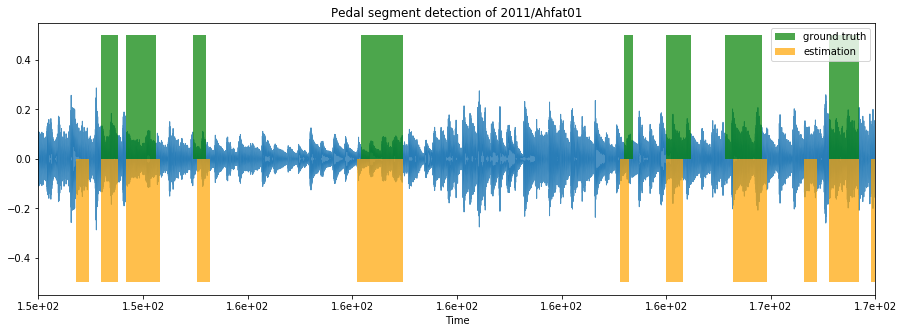

In [327]:
# plot result
frmtimes = np.arange(n_frames)*seghop_duration
left,right = [150,170]
plt.figure(figsize=(15,5))
librosa.display.waveplot(paudio, SR, alpha=0.8)
plt.fill_between(frmtimes, 0, 0.5, where=segframes_gt>0, facecolor='green', alpha=0.7, label='ground truth')
plt.fill_between(frmtimes, -0.5, 0, where=segframes_est>0, facecolor='orange', alpha=0.7, label='estimation')
plt.title("Pedal segment detection of {}".format(filename))
plt.legend()
plt.xlim([left,right])

In [ ]:
# paudio_rmse = librosa.feature.rmse(y=paudio, hop_length=HOP_LENGTH)
# paudio_rmse_norm = (paudio_rmse[0]-min(paudio_rmse[0]))/(max(paudio_rmse[0])-min(paudio_rmse[0]))
# paudio_rmse_norm_filter = medfilt(paudio_rmse_norm,11)
# frmtime_rmse = np.arange(len(paudio_rmse_norm))*0.01

# plt.figure(figsize=(20,8))
# axes = plt.gca()
# ymin, ymax = axes.get_ylim()
# # plt.axhline(0.98, label='seg threshold', color='gray')
# plt.vlines(pedal_onset_gt,ymin, ymax, label='gt onset', color='yellow', lw=2)
# plt.vlines(longseg_onset_gt, ymin, ymax, label='gt long onset', color='red', lw=2)
# plt.vlines(longseg_onset_gt+0.3, ymin, ymax, linestyles='dashed', color='black', lw=1)
# plt.vlines(pedal_offset_gt, ymin, ymax, label='gt offset', color='black', lw=2)
# plt.plot(frmtime_ponset, pred_ponset_todetect, '-', label='predicted pedal onset', alpha=0.7)
# plt.plot(frmtime_psegment, pred_psegment_todetect, '-', label='predicted pedal segment', alpha=0.5)
# for idx in range(len(onseg_times)):S
#     plt.axvspan(onseg_times[idx],offseg_times[idx], ymin, ymax, color='green', alpha=0.3)
# # plt.grid(True)
# # axes.minorticks_on()
# # axes.grid(which='minor')
# # plt.ylim([0.5,1])
# plt.xlim([150,170])
# plt.legend()